# Chapter 09 - Semisupervised Learning 

### Setup 

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
from tensorflow import keras
K = keras.backend

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

### Check library versions & set seed

In [2]:
import sys, sklearn
print(f'sklearn    {sklearn.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'keras      {keras.__version__}')
print(f'numpy      {np.__version__}')
print(f'lightgbp   {lgb.__version__}')

sklearn    0.20.3
tensorflow 2.1.0
keras      2.2.4-tf
numpy      1.17.2
lightgbp   2.3.1


In [3]:
# To make the output stable across runs
tf.random.set_seed(42)
np.random.seed(42)

## Data Preparation 

### Load the data 

In [4]:
# Load the data
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)

In [5]:
dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()

### Scale the data 

In [6]:
# Scale data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

### Split into train and test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.33, 
                                       random_state=2018, stratify=dataY)

In [8]:
print([x.shape for x in (X_train, X_test, y_train, y_test)])

[(190820, 29), (93987, 29), (190820,), (93987,)]


In [9]:
np.sum(y_train==0),np.sum(y_train==1)

(190490, 330)

### Drop 90% of the labels from the training set

In [10]:
toDrop = y_train[y_train==1].sample(frac=0.90,random_state=2018)
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)

/home/faisito/anaconda3/envs/tf2/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Check the number of fruadulant cases left after dropping 90% of the cases.

In [11]:
np.sum(y_train==0),np.sum(y_train==1)

(190490, 33)

### Define evaluation function and plotting function

In [12]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - 
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [13]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], 
                               preds['anomalyScore'])
    average_precision = average_precision_score( 
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], 
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

Define a new function to assess precision at a given recall threshold

In [14]:
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

## Supervised Model 

In [15]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

In [16]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [17]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, 
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), 
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index],   y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, 
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(
        X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print(f'Training Log Loss: {loglossTraining}')
    print(f'CV Log Loss: {loglossCV}')

[1]	valid_0's binary_logloss: 0.00516281
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00199983
[3]	valid_0's binary_logloss: 0.00235712
[4]	valid_0's binary_logloss: 0.00234997
[5]	valid_0's binary_logloss: 0.00230526
[6]	valid_0's binary_logloss: 0.00226783
[7]	valid_0's binary_logloss: 0.00223639
[8]	valid_0's binary_logloss: 0.00221215
[9]	valid_0's binary_logloss: 0.00218928
[10]	valid_0's binary_logloss: 0.00217154
[11]	valid_0's binary_logloss: 0.00215385
[12]	valid_0's binary_logloss: 0.00214024
[13]	valid_0's binary_logloss: 0.00212557
[14]	valid_0's binary_logloss: 0.00211323
[15]	valid_0's binary_logloss: 0.00210066
[16]	valid_0's binary_logloss: 0.00209014
[17]	valid_0's binary_logloss: 0.00207927
[18]	valid_0's binary_logloss: 0.00206909
[19]	valid_0's binary_logloss: 0.00205901
[20]	valid_0's binary_logloss: 0.00205012
[21]	valid_0's binary_logloss: 0.00204114
[22]	valid_0's binary_logloss: 0.00203291
[23]	valid_0's binary_l

[210]	valid_0's binary_logloss: 0.00165638
[211]	valid_0's binary_logloss: 0.00165553
[212]	valid_0's binary_logloss: 0.00165389
[213]	valid_0's binary_logloss: 0.00165361
[214]	valid_0's binary_logloss: 0.00165256
[215]	valid_0's binary_logloss: 0.00165113
[216]	valid_0's binary_logloss: 0.00165045
[217]	valid_0's binary_logloss: 0.00164886
[218]	valid_0's binary_logloss: 0.00164788
[219]	valid_0's binary_logloss: 0.0016471
[220]	valid_0's binary_logloss: 0.00164555
[221]	valid_0's binary_logloss: 0.00164431
[222]	valid_0's binary_logloss: 0.00164278
[223]	valid_0's binary_logloss: 0.00164259
[224]	valid_0's binary_logloss: 0.00164124
[225]	valid_0's binary_logloss: 0.00163987
[226]	valid_0's binary_logloss: 0.00163892
[227]	valid_0's binary_logloss: 0.00163757
[228]	valid_0's binary_logloss: 0.00163624
[229]	valid_0's binary_logloss: 0.00163493
[230]	valid_0's binary_logloss: 0.00163362
[231]	valid_0's binary_logloss: 0.00163236
[232]	valid_0's binary_logloss: 0.00163108
[233]	valid_

[407]	valid_0's binary_logloss: 0.00155413
[408]	valid_0's binary_logloss: 0.00155451
[409]	valid_0's binary_logloss: 0.00155432
[410]	valid_0's binary_logloss: 0.0015547
[411]	valid_0's binary_logloss: 0.00155439
[412]	valid_0's binary_logloss: 0.00155421
[413]	valid_0's binary_logloss: 0.00155462
[414]	valid_0's binary_logloss: 0.00155503
[415]	valid_0's binary_logloss: 0.0015556
[416]	valid_0's binary_logloss: 0.00155543
[417]	valid_0's binary_logloss: 0.00155585
[418]	valid_0's binary_logloss: 0.00155635
[419]	valid_0's binary_logloss: 0.00155596
[420]	valid_0's binary_logloss: 0.00155658
[421]	valid_0's binary_logloss: 0.0015562
[422]	valid_0's binary_logloss: 0.00155582
[423]	valid_0's binary_logloss: 0.00155644
[424]	valid_0's binary_logloss: 0.00155604
[425]	valid_0's binary_logloss: 0.00155567
[426]	valid_0's binary_logloss: 0.00155531
[427]	valid_0's binary_logloss: 0.00155516
[428]	valid_0's binary_logloss: 0.00155579
[429]	valid_0's binary_logloss: 0.00155544
[430]	valid_0'

[609]	valid_0's binary_logloss: 0.00158103
[610]	valid_0's binary_logloss: 0.00158051
[611]	valid_0's binary_logloss: 0.00158133
[612]	valid_0's binary_logloss: 0.0015823
[613]	valid_0's binary_logloss: 0.00158316
[614]	valid_0's binary_logloss: 0.00158294
[615]	valid_0's binary_logloss: 0.0015838
[616]	valid_0's binary_logloss: 0.00158459
[617]	valid_0's binary_logloss: 0.00158408
[618]	valid_0's binary_logloss: 0.00158479
[619]	valid_0's binary_logloss: 0.00158428
[620]	valid_0's binary_logloss: 0.00158378
[621]	valid_0's binary_logloss: 0.00158356
[622]	valid_0's binary_logloss: 0.0015844
[623]	valid_0's binary_logloss: 0.00158522
[624]	valid_0's binary_logloss: 0.00158501
[625]	valid_0's binary_logloss: 0.0015858
[626]	valid_0's binary_logloss: 0.0015853
[627]	valid_0's binary_logloss: 0.00158609
[628]	valid_0's binary_logloss: 0.00158559
[629]	valid_0's binary_logloss: 0.00158515
[630]	valid_0's binary_logloss: 0.00158599
[631]	valid_0's binary_logloss: 0.00158556
[632]	valid_0's 

[104]	valid_0's binary_logloss: 0.00303082
[105]	valid_0's binary_logloss: 0.00302575
[106]	valid_0's binary_logloss: 0.00301989
[107]	valid_0's binary_logloss: 0.00301506
[108]	valid_0's binary_logloss: 0.0030102
[109]	valid_0's binary_logloss: 0.00300676
[110]	valid_0's binary_logloss: 0.0030017
[111]	valid_0's binary_logloss: 0.00299712
[112]	valid_0's binary_logloss: 0.00299171
[113]	valid_0's binary_logloss: 0.00298672
[114]	valid_0's binary_logloss: 0.00298235
[115]	valid_0's binary_logloss: 0.00297848
[116]	valid_0's binary_logloss: 0.00297416
[117]	valid_0's binary_logloss: 0.00296996
[118]	valid_0's binary_logloss: 0.00296533
[119]	valid_0's binary_logloss: 0.00296227
[120]	valid_0's binary_logloss: 0.00296481
[121]	valid_0's binary_logloss: 0.00296064
[122]	valid_0's binary_logloss: 0.00295522
[123]	valid_0's binary_logloss: 0.00295538
[124]	valid_0's binary_logloss: 0.00295132
[125]	valid_0's binary_logloss: 0.00294615
[126]	valid_0's binary_logloss: 0.00294297
[127]	valid_0

[101]	valid_0's binary_logloss: 0.00184155
[102]	valid_0's binary_logloss: 0.00184024
[103]	valid_0's binary_logloss: 0.00183894
[104]	valid_0's binary_logloss: 0.00183767
[105]	valid_0's binary_logloss: 0.00183641
[106]	valid_0's binary_logloss: 0.00183518
[107]	valid_0's binary_logloss: 0.00183396
[108]	valid_0's binary_logloss: 0.00183277
[109]	valid_0's binary_logloss: 0.0018316
[110]	valid_0's binary_logloss: 0.00182957
[111]	valid_0's binary_logloss: 0.00182789
[112]	valid_0's binary_logloss: 0.00182591
[113]	valid_0's binary_logloss: 0.00182397
[114]	valid_0's binary_logloss: 0.00182205
[115]	valid_0's binary_logloss: 0.00182094
[116]	valid_0's binary_logloss: 0.00181985
[117]	valid_0's binary_logloss: 0.00181877
[118]	valid_0's binary_logloss: 0.00181771
[119]	valid_0's binary_logloss: 0.00181668
[120]	valid_0's binary_logloss: 0.00181566
[121]	valid_0's binary_logloss: 0.00181465
[122]	valid_0's binary_logloss: 0.0018129
[123]	valid_0's binary_logloss: 0.00181192
[124]	valid_0

[297]	valid_0's binary_logloss: 0.00175246
[298]	valid_0's binary_logloss: 0.00175266
[299]	valid_0's binary_logloss: 0.0017538
[300]	valid_0's binary_logloss: 0.00175465
[301]	valid_0's binary_logloss: 0.00175563
[302]	valid_0's binary_logloss: 0.00175485
[303]	valid_0's binary_logloss: 0.00175498
[304]	valid_0's binary_logloss: 0.00175598
[305]	valid_0's binary_logloss: 0.00175521
[306]	valid_0's binary_logloss: 0.00175535
[307]	valid_0's binary_logloss: 0.00175635
[308]	valid_0's binary_logloss: 0.00175636
[309]	valid_0's binary_logloss: 0.00175659
[310]	valid_0's binary_logloss: 0.0017576
[311]	valid_0's binary_logloss: 0.00175861
[312]	valid_0's binary_logloss: 0.00175877
[313]	valid_0's binary_logloss: 0.00175978
[314]	valid_0's binary_logloss: 0.00176002
[315]	valid_0's binary_logloss: 0.00176108
[316]	valid_0's binary_logloss: 0.0017621
[317]	valid_0's binary_logloss: 0.00176235
[318]	valid_0's binary_logloss: 0.00176342
[319]	valid_0's binary_logloss: 0.00176445
[320]	valid_0'

[80]	valid_0's binary_logloss: 0.00259814
[81]	valid_0's binary_logloss: 0.00259517
[82]	valid_0's binary_logloss: 0.00259225
[83]	valid_0's binary_logloss: 0.00258967
[84]	valid_0's binary_logloss: 0.00258683
[85]	valid_0's binary_logloss: 0.00258441
[86]	valid_0's binary_logloss: 0.0025816
[87]	valid_0's binary_logloss: 0.00257926
[88]	valid_0's binary_logloss: 0.00257659
[89]	valid_0's binary_logloss: 0.00257428
[90]	valid_0's binary_logloss: 0.0025717
[91]	valid_0's binary_logloss: 0.00256914
[92]	valid_0's binary_logloss: 0.00256637
[93]	valid_0's binary_logloss: 0.00256389
[94]	valid_0's binary_logloss: 0.00256145
[95]	valid_0's binary_logloss: 0.00256141
[96]	valid_0's binary_logloss: 0.00255948
[97]	valid_0's binary_logloss: 0.00255944
[98]	valid_0's binary_logloss: 0.00255755
[99]	valid_0's binary_logloss: 0.00255569
[100]	valid_0's binary_logloss: 0.00255571
[101]	valid_0's binary_logloss: 0.0025539
[102]	valid_0's binary_logloss: 0.00255211
[103]	valid_0's binary_logloss: 0.

[286]	valid_0's binary_logloss: 0.00232238
[287]	valid_0's binary_logloss: 0.00232161
[288]	valid_0's binary_logloss: 0.00232052
[289]	valid_0's binary_logloss: 0.00231974
[290]	valid_0's binary_logloss: 0.00231898
[291]	valid_0's binary_logloss: 0.00231824
[292]	valid_0's binary_logloss: 0.00231719
[293]	valid_0's binary_logloss: 0.00231636
[294]	valid_0's binary_logloss: 0.00231609
[295]	valid_0's binary_logloss: 0.00231538
[296]	valid_0's binary_logloss: 0.00231465
[297]	valid_0's binary_logloss: 0.00231396
[298]	valid_0's binary_logloss: 0.00231327
[299]	valid_0's binary_logloss: 0.00231226
[300]	valid_0's binary_logloss: 0.0023116
[301]	valid_0's binary_logloss: 0.00231094
[302]	valid_0's binary_logloss: 0.00231028
[303]	valid_0's binary_logloss: 0.0023093
[304]	valid_0's binary_logloss: 0.00230865
[305]	valid_0's binary_logloss: 0.00230843
[306]	valid_0's binary_logloss: 0.00230804
[307]	valid_0's binary_logloss: 0.00230782
[308]	valid_0's binary_logloss: 0.00230764
[309]	valid_0

[500]	valid_0's binary_logloss: 0.00225197
[501]	valid_0's binary_logloss: 0.00225215
[502]	valid_0's binary_logloss: 0.00225205
[503]	valid_0's binary_logloss: 0.00225257
[504]	valid_0's binary_logloss: 0.00225223
[505]	valid_0's binary_logloss: 0.00225208
[506]	valid_0's binary_logloss: 0.00225206
[507]	valid_0's binary_logloss: 0.00225134
[508]	valid_0's binary_logloss: 0.0022518
[509]	valid_0's binary_logloss: 0.00225171
[510]	valid_0's binary_logloss: 0.00225225
[511]	valid_0's binary_logloss: 0.00225271
[512]	valid_0's binary_logloss: 0.00225259
[513]	valid_0's binary_logloss: 0.00225189
[514]	valid_0's binary_logloss: 0.00225235
[515]	valid_0's binary_logloss: 0.00225162
[516]	valid_0's binary_logloss: 0.00225168
[517]	valid_0's binary_logloss: 0.00225161
[518]	valid_0's binary_logloss: 0.00225215
[519]	valid_0's binary_logloss: 0.00225262
[520]	valid_0's binary_logloss: 0.00225317
[521]	valid_0's binary_logloss: 0.00225248
[522]	valid_0's binary_logloss: 0.00225177
[523]	valid_

[57]	valid_0's binary_logloss: 0.0027705
[58]	valid_0's binary_logloss: 0.00275915
[59]	valid_0's binary_logloss: 0.00274961
[60]	valid_0's binary_logloss: 0.00274023
[61]	valid_0's binary_logloss: 0.00273065
[62]	valid_0's binary_logloss: 0.00272117
[63]	valid_0's binary_logloss: 0.00271175
[64]	valid_0's binary_logloss: 0.00270312
[65]	valid_0's binary_logloss: 0.00269383
[66]	valid_0's binary_logloss: 0.00268498
[67]	valid_0's binary_logloss: 0.00267624
[68]	valid_0's binary_logloss: 0.00266765
[69]	valid_0's binary_logloss: 0.00266361
[70]	valid_0's binary_logloss: 0.00251487
[71]	valid_0's binary_logloss: 0.00251715
[72]	valid_0's binary_logloss: 0.00251823
[73]	valid_0's binary_logloss: 0.00251788
[74]	valid_0's binary_logloss: 0.00251365
[75]	valid_0's binary_logloss: 0.00251268
[76]	valid_0's binary_logloss: 0.00251112
[77]	valid_0's binary_logloss: 0.00250656
[78]	valid_0's binary_logloss: 0.00250206
[79]	valid_0's binary_logloss: 0.0024976
[80]	valid_0's binary_logloss: 0.002

[256]	valid_0's binary_logloss: 0.00187788
[257]	valid_0's binary_logloss: 0.00187532
[258]	valid_0's binary_logloss: 0.00187403
[259]	valid_0's binary_logloss: 0.00187204
[260]	valid_0's binary_logloss: 0.00187037
[261]	valid_0's binary_logloss: 0.00186911
[262]	valid_0's binary_logloss: 0.00186717
[263]	valid_0's binary_logloss: 0.00186553
[264]	valid_0's binary_logloss: 0.0018639
[265]	valid_0's binary_logloss: 0.00186086
[266]	valid_0's binary_logloss: 0.00186021
[267]	valid_0's binary_logloss: 0.00185758
[268]	valid_0's binary_logloss: 0.00185641
[269]	valid_0's binary_logloss: 0.00185526
[270]	valid_0's binary_logloss: 0.00185412
[271]	valid_0's binary_logloss: 0.00185302
[272]	valid_0's binary_logloss: 0.00185191
[273]	valid_0's binary_logloss: 0.00185082
[274]	valid_0's binary_logloss: 0.00184974
[275]	valid_0's binary_logloss: 0.00184867
[276]	valid_0's binary_logloss: 0.00184761
[277]	valid_0's binary_logloss: 0.00184585
[278]	valid_0's binary_logloss: 0.0018441
[279]	valid_0

[451]	valid_0's binary_logloss: 0.00168519
[452]	valid_0's binary_logloss: 0.00168454
[453]	valid_0's binary_logloss: 0.0016837
[454]	valid_0's binary_logloss: 0.00168341
[455]	valid_0's binary_logloss: 0.00168253
[456]	valid_0's binary_logloss: 0.00168238
[457]	valid_0's binary_logloss: 0.00168196
[458]	valid_0's binary_logloss: 0.00168172
[459]	valid_0's binary_logloss: 0.00168089
[460]	valid_0's binary_logloss: 0.00168062
[461]	valid_0's binary_logloss: 0.00167876
[462]	valid_0's binary_logloss: 0.0016779
[463]	valid_0's binary_logloss: 0.00167727
[464]	valid_0's binary_logloss: 0.00167765
[465]	valid_0's binary_logloss: 0.00167684
[466]	valid_0's binary_logloss: 0.00167671
[467]	valid_0's binary_logloss: 0.00167586
[468]	valid_0's binary_logloss: 0.00167625
[469]	valid_0's binary_logloss: 0.00167543
[470]	valid_0's binary_logloss: 0.00167517
[471]	valid_0's binary_logloss: 0.00167335
[472]	valid_0's binary_logloss: 0.00167295
[473]	valid_0's binary_logloss: 0.0016727
[474]	valid_0'

[659]	valid_0's binary_logloss: 0.00162035
[660]	valid_0's binary_logloss: 0.00161972
[661]	valid_0's binary_logloss: 0.00161911
[662]	valid_0's binary_logloss: 0.00161894
[663]	valid_0's binary_logloss: 0.00161852
[664]	valid_0's binary_logloss: 0.00161844
[665]	valid_0's binary_logloss: 0.00161802
[666]	valid_0's binary_logloss: 0.0016169
[667]	valid_0's binary_logloss: 0.00161679
[668]	valid_0's binary_logloss: 0.00161701
[669]	valid_0's binary_logloss: 0.00161685
[670]	valid_0's binary_logloss: 0.00161664
[671]	valid_0's binary_logloss: 0.00161649
[672]	valid_0's binary_logloss: 0.00161638
[673]	valid_0's binary_logloss: 0.0016161
[674]	valid_0's binary_logloss: 0.00161584
[675]	valid_0's binary_logloss: 0.00161523
[676]	valid_0's binary_logloss: 0.00161504
[677]	valid_0's binary_logloss: 0.00161443
[678]	valid_0's binary_logloss: 0.0016138
[679]	valid_0's binary_logloss: 0.00161354
[680]	valid_0's binary_logloss: 0.00161294
[681]	valid_0's binary_logloss: 0.00161231
[682]	valid_0'

[865]	valid_0's binary_logloss: 0.00157579
[866]	valid_0's binary_logloss: 0.00157581
[867]	valid_0's binary_logloss: 0.00157497
[868]	valid_0's binary_logloss: 0.00157465
[869]	valid_0's binary_logloss: 0.00157447
[870]	valid_0's binary_logloss: 0.00157566
[871]	valid_0's binary_logloss: 0.00157568
[872]	valid_0's binary_logloss: 0.00157484
[873]	valid_0's binary_logloss: 0.00157453
[874]	valid_0's binary_logloss: 0.00157571
[875]	valid_0's binary_logloss: 0.00157544
[876]	valid_0's binary_logloss: 0.00157454
[877]	valid_0's binary_logloss: 0.00157474
[878]	valid_0's binary_logloss: 0.00157586
[879]	valid_0's binary_logloss: 0.0015755
[880]	valid_0's binary_logloss: 0.00157571
[881]	valid_0's binary_logloss: 0.00157534
[882]	valid_0's binary_logloss: 0.00157517
[883]	valid_0's binary_logloss: 0.0015749
[884]	valid_0's binary_logloss: 0.00157609
[885]	valid_0's binary_logloss: 0.00157578
[886]	valid_0's binary_logloss: 0.0015758
[887]	valid_0's binary_logloss: 0.00157699
[888]	valid_0'

[1063]	valid_0's binary_logloss: 0.0015607
[1064]	valid_0's binary_logloss: 0.00156042
[1065]	valid_0's binary_logloss: 0.00156072
[1066]	valid_0's binary_logloss: 0.00156048
[1067]	valid_0's binary_logloss: 0.00156183
[1068]	valid_0's binary_logloss: 0.00156108
[1069]	valid_0's binary_logloss: 0.00156083
[1070]	valid_0's binary_logloss: 0.00156178
[1071]	valid_0's binary_logloss: 0.0015627
[1072]	valid_0's binary_logloss: 0.00156242
[1073]	valid_0's binary_logloss: 0.00156377
[1074]	valid_0's binary_logloss: 0.00156471
[1075]	valid_0's binary_logloss: 0.00156474
[1076]	valid_0's binary_logloss: 0.00156385
[1077]	valid_0's binary_logloss: 0.00156372
[1078]	valid_0's binary_logloss: 0.00156284
[1079]	valid_0's binary_logloss: 0.0015637
[1080]	valid_0's binary_logloss: 0.00156283
[1081]	valid_0's binary_logloss: 0.00156417
[1082]	valid_0's binary_logloss: 0.00156405
[1083]	valid_0's binary_logloss: 0.00156318
[1084]	valid_0's binary_logloss: 0.00156231
[1085]	valid_0's binary_logloss: 0.

In [18]:
loglossLightGBMGradientBoosting = log_loss(y_train, 
        predictionsBasedOnKFolds.loc[:,'prediction'])
print(f'LightGBM Gradient Boosting Log Loss: {round(loglossLightGBMGradientBoosting,4)}')

LightGBM Gradient Boosting Log Loss: 0.0018


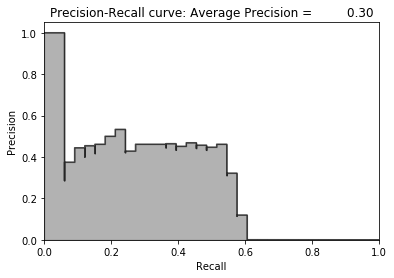

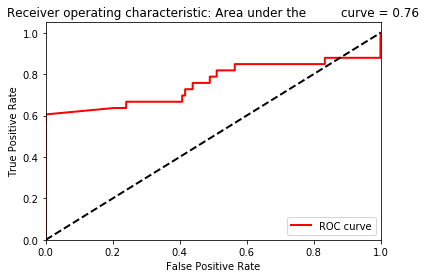

In [19]:
preds, average_precision = plotResults(y_train, 
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

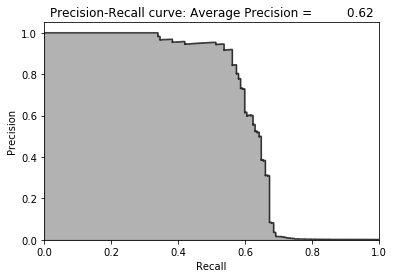

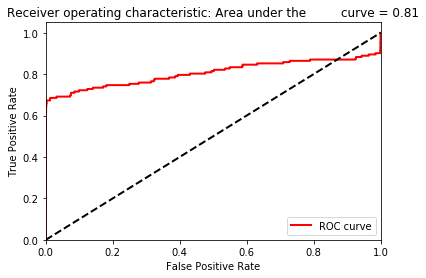

In [20]:
predictions = pd.Series(data=gbm.predict(X_test, 
                num_iteration=gbm.best_iteration), index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [21]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(f'Precision at 75% recall {round(precision,4)}')

Precision at 75% recall 0.0047


## Unsupervised Model

Take the 33 fraudulent cases, duplicate these 100 times and then append them to the training set

In [22]:
oversample_multiplier = 100

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

X_train_oversampled = X_train.copy()
y_train_oversampled = y_train.copy()
X_train_oversampled = X_train_oversampled.append( \
        [X_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)
y_train_oversampled = y_train_oversampled.append( \
        [y_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)

X_train = X_train_oversampled.copy()
y_train = y_train_oversampled.copy()

In [23]:
X_train.shape, y_train.shape

((193823, 29), (193823,))

A sparse two-layer overcomplete autoencoder with a linear a linear activation function.  
Forty nodes in the hidden layer and a dropout of 2%

In [24]:
model = Sequential()
model.add(Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(1e-4),
                input_dim=29, name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=29, activation='linear'))

In [25]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [26]:
num_epochs =  5
batch_size = 32

history = model.fit(x=X_train, y=X_train, epochs=num_epochs, batch_size=batch_size, shuffle=True,
                    validation_split=0.20, verbose=1)

Train on 155058 samples, validate on 38765 samples
Epoch 1/5
155058/155058 [==============================] - 4s 27us/sample - loss: 0.0729 - accuracy: 0.8671 - val_loss: 0.0698 - val_accuracy: 0.9660
Epoch 2/5
155058/155058 [==============================] - 4s 25us/sample - loss: 0.0182 - accuracy: 0.9263 - val_loss: 0.0262 - val_accuracy: 0.9795
Epoch 3/5
155058/155058 [==============================] - 4s 26us/sample - loss: 0.0177 - accuracy: 0.9266 - val_loss: 0.0165 - val_accuracy: 0.9835
Epoch 4/5
155058/155058 [==============================] - 4s 26us/sample - loss: 0.0169 - accuracy: 0.9269 - val_loss: 0.0195 - val_accuracy: 0.9834
Epoch 5/5
155058/155058 [==============================] - 4s 27us/sample - loss: 0.0176 - accuracy: 0.9259 - val_loss: 0.0066 - val_accuracy: 0.9828


190523/190523 [==============================] - 2s 12us/sample


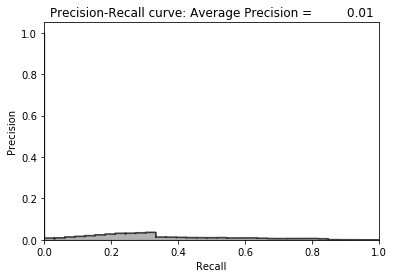

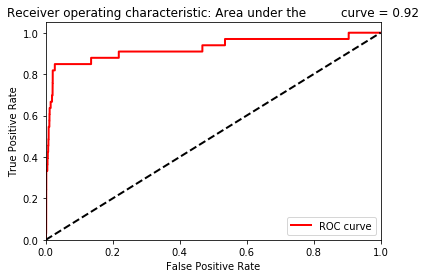

In [27]:
predictionsTrain = model.predict(X_train_original, verbose=1)
anomalyScoresAETrain = anomalyScores(X_train_original, predictionsTrain)
preds, average_precision = plotResults(y_train_original, anomalyScoresAETrain, True)

93987/93987 [==============================] - 1s 11us/sample


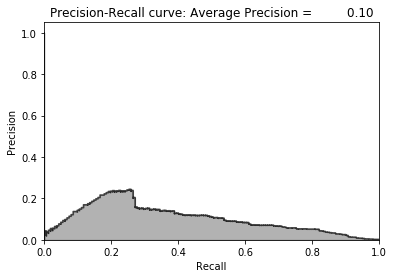

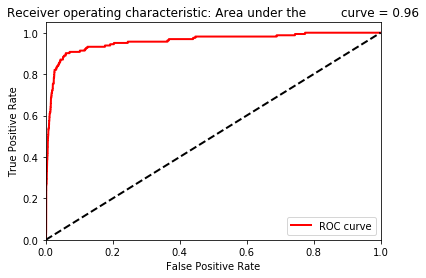

In [28]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, average_precision = plotResults(y_test, anomalyScoresAE, True)

In [29]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(f'Precision at 75% recall {round(precision,4)}')

Precision at 75% recall 0.0532


## Semisupervised Model

In [30]:
layer_name = 'hidden_layer'

intermediate_layer_model  = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_output_train = intermediate_layer_model.predict(X_train_original)
intermediate_output_test  = intermediate_layer_model.predict(X_test_original)

In [31]:
intermediate_output_trainDF = pd.DataFrame(data=intermediate_output_train,index=X_train_original.index)
intermediate_output_testDF  = pd.DataFrame(data=intermediate_output_test,index=X_test_original.index)

In [32]:
X_train = X_train_original.merge(intermediate_output_trainDF, left_index=True,right_index=True)
X_test  = X_test_original.merge(intermediate_output_testDF, left_index=True,right_index=True)
y_train = y_train_original.copy()

In [33]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,  columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=5000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold,num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print(f'Training Log Loss: {round(loglossTraining,4)}')
    print(f'CV Log Loss: {round(loglossCV,4)}' )

[1]	valid_0's binary_logloss: 0.00651864
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00613787
[3]	valid_0's binary_logloss: 0.00568419
[4]	valid_0's binary_logloss: 0.00563349
[5]	valid_0's binary_logloss: 0.00557326
[6]	valid_0's binary_logloss: 0.00555163
[7]	valid_0's binary_logloss: 0.00553373
[8]	valid_0's binary_logloss: 0.00553608
[9]	valid_0's binary_logloss: 0.00552869
[10]	valid_0's binary_logloss: 0.00551911
[11]	valid_0's binary_logloss: 0.00550907
[12]	valid_0's binary_logloss: 0.00549466
[13]	valid_0's binary_logloss: 0.0054812
[14]	valid_0's binary_logloss: 0.00547163
[15]	valid_0's binary_logloss: 0.00545963
[16]	valid_0's binary_logloss: 0.00544823
[17]	valid_0's binary_logloss: 0.00543743
[18]	valid_0's binary_logloss: 0.00542714
[19]	valid_0's binary_logloss: 0.0054173
[20]	valid_0's binary_logloss: 0.00540892
[21]	valid_0's binary_logloss: 0.0053979
[22]	valid_0's binary_logloss: 0.00538993
[23]	valid_0's binary_logl

[205]	valid_0's binary_logloss: 0.00474781
[206]	valid_0's binary_logloss: 0.0047463
[207]	valid_0's binary_logloss: 0.00474535
[208]	valid_0's binary_logloss: 0.0047437
[209]	valid_0's binary_logloss: 0.00474277
[210]	valid_0's binary_logloss: 0.00474131
[211]	valid_0's binary_logloss: 0.00474038
[212]	valid_0's binary_logloss: 0.00473878
[213]	valid_0's binary_logloss: 0.00473787
[214]	valid_0's binary_logloss: 0.00473645
[215]	valid_0's binary_logloss: 0.00473556
[216]	valid_0's binary_logloss: 0.00473468
[217]	valid_0's binary_logloss: 0.00473311
[218]	valid_0's binary_logloss: 0.00473172
[219]	valid_0's binary_logloss: 0.00473085
[220]	valid_0's binary_logloss: 0.00473
[221]	valid_0's binary_logloss: 0.00472847
[222]	valid_0's binary_logloss: 0.0047271
[223]	valid_0's binary_logloss: 0.00472627
[224]	valid_0's binary_logloss: 0.00472545
[225]	valid_0's binary_logloss: 0.00472411
[226]	valid_0's binary_logloss: 0.00472261
[227]	valid_0's binary_logloss: 0.0047218
[228]	valid_0's bi

[400]	valid_0's binary_logloss: 0.00450081
[401]	valid_0's binary_logloss: 0.00449978
[402]	valid_0's binary_logloss: 0.00449876
[403]	valid_0's binary_logloss: 0.00449774
[404]	valid_0's binary_logloss: 0.00449673
[405]	valid_0's binary_logloss: 0.00449571
[406]	valid_0's binary_logloss: 0.0044945
[407]	valid_0's binary_logloss: 0.0044935
[408]	valid_0's binary_logloss: 0.00449229
[409]	valid_0's binary_logloss: 0.00449129
[410]	valid_0's binary_logloss: 0.00449029
[411]	valid_0's binary_logloss: 0.0044893
[412]	valid_0's binary_logloss: 0.00448811
[413]	valid_0's binary_logloss: 0.00448712
[414]	valid_0's binary_logloss: 0.00448593
[415]	valid_0's binary_logloss: 0.00448495
[416]	valid_0's binary_logloss: 0.00448397
[417]	valid_0's binary_logloss: 0.00448251
[418]	valid_0's binary_logloss: 0.00448154
[419]	valid_0's binary_logloss: 0.00448057
[420]	valid_0's binary_logloss: 0.00447922
[421]	valid_0's binary_logloss: 0.00447825
[422]	valid_0's binary_logloss: 0.00447654
[423]	valid_0'

[595]	valid_0's binary_logloss: 0.00431424
[596]	valid_0's binary_logloss: 0.0043133
[597]	valid_0's binary_logloss: 0.00431287
[598]	valid_0's binary_logloss: 0.0043124
[599]	valid_0's binary_logloss: 0.00431148
[600]	valid_0's binary_logloss: 0.00431147
[601]	valid_0's binary_logloss: 0.00431054
[602]	valid_0's binary_logloss: 0.00430978
[603]	valid_0's binary_logloss: 0.00430931
[604]	valid_0's binary_logloss: 0.00430843
[605]	valid_0's binary_logloss: 0.00430752
[606]	valid_0's binary_logloss: 0.00430751
[607]	valid_0's binary_logloss: 0.00430663
[608]	valid_0's binary_logloss: 0.00430575
[609]	valid_0's binary_logloss: 0.00430487
[610]	valid_0's binary_logloss: 0.00430399
[611]	valid_0's binary_logloss: 0.00430311
[612]	valid_0's binary_logloss: 0.00430223
[613]	valid_0's binary_logloss: 0.00430224
[614]	valid_0's binary_logloss: 0.00430136
[615]	valid_0's binary_logloss: 0.00430049
[616]	valid_0's binary_logloss: 0.00429962
[617]	valid_0's binary_logloss: 0.00429875
[618]	valid_0

[790]	valid_0's binary_logloss: 0.00421679
[791]	valid_0's binary_logloss: 0.00421663
[792]	valid_0's binary_logloss: 0.00421685
[793]	valid_0's binary_logloss: 0.00421586
[794]	valid_0's binary_logloss: 0.0042158
[795]	valid_0's binary_logloss: 0.00421563
[796]	valid_0's binary_logloss: 0.00421547
[797]	valid_0's binary_logloss: 0.00421448
[798]	valid_0's binary_logloss: 0.0042147
[799]	valid_0's binary_logloss: 0.00421464
[800]	valid_0's binary_logloss: 0.00421433
[801]	valid_0's binary_logloss: 0.00421418
[802]	valid_0's binary_logloss: 0.00421438
[803]	valid_0's binary_logloss: 0.00421436
[804]	valid_0's binary_logloss: 0.00421457
[805]	valid_0's binary_logloss: 0.00421451
[806]	valid_0's binary_logloss: 0.00421351
[807]	valid_0's binary_logloss: 0.00421336
[808]	valid_0's binary_logloss: 0.00421318
[809]	valid_0's binary_logloss: 0.00421234
[810]	valid_0's binary_logloss: 0.0042115
[811]	valid_0's binary_logloss: 0.00421066
[812]	valid_0's binary_logloss: 0.00420983
[813]	valid_0'

[999]	valid_0's binary_logloss: 0.00416163
[1000]	valid_0's binary_logloss: 0.00416151
[1001]	valid_0's binary_logloss: 0.0041613
[1002]	valid_0's binary_logloss: 0.00416104
[1003]	valid_0's binary_logloss: 0.00416126
[1004]	valid_0's binary_logloss: 0.00416081
[1005]	valid_0's binary_logloss: 0.00416113
[1006]	valid_0's binary_logloss: 0.00416135
[1007]	valid_0's binary_logloss: 0.00416152
[1008]	valid_0's binary_logloss: 0.00416155
[1009]	valid_0's binary_logloss: 0.00416187
[1010]	valid_0's binary_logloss: 0.00416151
[1011]	valid_0's binary_logloss: 0.00416183
[1012]	valid_0's binary_logloss: 0.00416189
[1013]	valid_0's binary_logloss: 0.0041621
[1014]	valid_0's binary_logloss: 0.00416157
[1015]	valid_0's binary_logloss: 0.00416189
[1016]	valid_0's binary_logloss: 0.00416203
[1017]	valid_0's binary_logloss: 0.0041615
[1018]	valid_0's binary_logloss: 0.00416183
[1019]	valid_0's binary_logloss: 0.00416187
[1020]	valid_0's binary_logloss: 0.00416134
[1021]	valid_0's binary_logloss: 0.0

[1204]	valid_0's binary_logloss: 0.00414821
[1205]	valid_0's binary_logloss: 0.00414863
[1206]	valid_0's binary_logloss: 0.00414882
[1207]	valid_0's binary_logloss: 0.0041489
[1208]	valid_0's binary_logloss: 0.00414912
[1209]	valid_0's binary_logloss: 0.00414878
[1210]	valid_0's binary_logloss: 0.00414849
[1211]	valid_0's binary_logloss: 0.00414844
[1212]	valid_0's binary_logloss: 0.00414862
[1213]	valid_0's binary_logloss: 0.00414871
[1214]	valid_0's binary_logloss: 0.0041488
[1215]	valid_0's binary_logloss: 0.00414903
[1216]	valid_0's binary_logloss: 0.00414945
[1217]	valid_0's binary_logloss: 0.00414911
[1218]	valid_0's binary_logloss: 0.0041493
[1219]	valid_0's binary_logloss: 0.00414938
[1220]	valid_0's binary_logloss: 0.00414949
[1221]	valid_0's binary_logloss: 0.00414971
[1222]	valid_0's binary_logloss: 0.0041498
[1223]	valid_0's binary_logloss: 0.00414951
[1224]	valid_0's binary_logloss: 0.00414916
[1225]	valid_0's binary_logloss: 0.00414929
[1226]	valid_0's binary_logloss: 0.0

[55]	valid_0's binary_logloss: 0.00534477
[56]	valid_0's binary_logloss: 0.00533741
[57]	valid_0's binary_logloss: 0.00533029
[58]	valid_0's binary_logloss: 0.00532458
[59]	valid_0's binary_logloss: 0.00531723
[60]	valid_0's binary_logloss: 0.0053116
[61]	valid_0's binary_logloss: 0.00530451
[62]	valid_0's binary_logloss: 0.00529748
[63]	valid_0's binary_logloss: 0.00529211
[64]	valid_0's binary_logloss: 0.00528623
[65]	valid_0's binary_logloss: 0.00528045
[66]	valid_0's binary_logloss: 0.00527476
[67]	valid_0's binary_logloss: 0.00528544
[68]	valid_0's binary_logloss: 0.0052796
[69]	valid_0's binary_logloss: 0.00527385
[70]	valid_0's binary_logloss: 0.00526855
[71]	valid_0's binary_logloss: 0.00526298
[72]	valid_0's binary_logloss: 0.00525884
[73]	valid_0's binary_logloss: 0.00525365
[74]	valid_0's binary_logloss: 0.00524835
[75]	valid_0's binary_logloss: 0.00524364
[76]	valid_0's binary_logloss: 0.00523762
[77]	valid_0's binary_logloss: 0.00523188
[78]	valid_0's binary_logloss: 0.005

[60]	valid_0's binary_logloss: 0.00214773
[61]	valid_0's binary_logloss: 0.0021356
[62]	valid_0's binary_logloss: 0.00212993
[63]	valid_0's binary_logloss: 0.00212516
[64]	valid_0's binary_logloss: 0.00211971
[65]	valid_0's binary_logloss: 0.00211075
[66]	valid_0's binary_logloss: 0.00210478
[67]	valid_0's binary_logloss: 0.00209501
[68]	valid_0's binary_logloss: 0.00208921
[69]	valid_0's binary_logloss: 0.00207942
[70]	valid_0's binary_logloss: 0.00207375
[71]	valid_0's binary_logloss: 0.00206429
[72]	valid_0's binary_logloss: 0.00205883
[73]	valid_0's binary_logloss: 0.00204956
[74]	valid_0's binary_logloss: 0.0020442
[75]	valid_0's binary_logloss: 0.0020387
[76]	valid_0's binary_logloss: 0.00202965
[77]	valid_0's binary_logloss: 0.0020245
[78]	valid_0's binary_logloss: 0.00202074
[79]	valid_0's binary_logloss: 0.00201196
[80]	valid_0's binary_logloss: 0.00196843
[81]	valid_0's binary_logloss: 0.00195906
[82]	valid_0's binary_logloss: 0.00195665
[83]	valid_0's binary_logloss: 0.00195

[51]	valid_0's binary_logloss: 0.0009085
[52]	valid_0's binary_logloss: 0.000906997
[53]	valid_0's binary_logloss: 0.000905554
[54]	valid_0's binary_logloss: 0.000904166
[55]	valid_0's binary_logloss: 0.000902838
[56]	valid_0's binary_logloss: 0.000901499
[57]	valid_0's binary_logloss: 0.000900228
[58]	valid_0's binary_logloss: 0.000899025
[59]	valid_0's binary_logloss: 0.000898142
[60]	valid_0's binary_logloss: 0.000897202
[61]	valid_0's binary_logloss: 0.000896631
[62]	valid_0's binary_logloss: 0.000895745
[63]	valid_0's binary_logloss: 0.000894824
[64]	valid_0's binary_logloss: 0.000893747
[65]	valid_0's binary_logloss: 0.000892702
[66]	valid_0's binary_logloss: 0.0008918
[67]	valid_0's binary_logloss: 0.000890817
[68]	valid_0's binary_logloss: 0.000889929
[69]	valid_0's binary_logloss: 0.000888892
[70]	valid_0's binary_logloss: 0.000887932
[71]	valid_0's binary_logloss: 0.000887036
[72]	valid_0's binary_logloss: 0.000886168
[73]	valid_0's binary_logloss: 0.00088526
[74]	valid_0's b

[255]	valid_0's binary_logloss: 0.000929012
[256]	valid_0's binary_logloss: 0.000929816
[257]	valid_0's binary_logloss: 0.000930623
[258]	valid_0's binary_logloss: 0.00093143
[259]	valid_0's binary_logloss: 0.000932241
[260]	valid_0's binary_logloss: 0.000933052
[261]	valid_0's binary_logloss: 0.000933876
[262]	valid_0's binary_logloss: 0.000934692
[263]	valid_0's binary_logloss: 0.000935518
[264]	valid_0's binary_logloss: 0.000936343
[265]	valid_0's binary_logloss: 0.000937176
[266]	valid_0's binary_logloss: 0.000938004
[267]	valid_0's binary_logloss: 0.000938834
[268]	valid_0's binary_logloss: 0.000939664
[269]	valid_0's binary_logloss: 0.000940506
[270]	valid_0's binary_logloss: 0.000941344
[271]	valid_0's binary_logloss: 0.00094218
[272]	valid_0's binary_logloss: 0.000943021
[273]	valid_0's binary_logloss: 0.000943871
[274]	valid_0's binary_logloss: 0.00094472
[275]	valid_0's binary_logloss: 0.000945568
[276]	valid_0's binary_logloss: 0.000946415
[277]	valid_0's binary_logloss: 0.0

[130]	valid_0's binary_logloss: 0.00282763
[131]	valid_0's binary_logloss: 0.00282279
[132]	valid_0's binary_logloss: 0.00281802
[133]	valid_0's binary_logloss: 0.00281322
[134]	valid_0's binary_logloss: 0.00280782
[135]	valid_0's binary_logloss: 0.00280244
[136]	valid_0's binary_logloss: 0.0027972
[137]	valid_0's binary_logloss: 0.00279257
[138]	valid_0's binary_logloss: 0.00278732
[139]	valid_0's binary_logloss: 0.00278212
[140]	valid_0's binary_logloss: 0.00277749
[141]	valid_0's binary_logloss: 0.00277238
[142]	valid_0's binary_logloss: 0.00276769
[143]	valid_0's binary_logloss: 0.00276321
[144]	valid_0's binary_logloss: 0.0027586
[145]	valid_0's binary_logloss: 0.0027554
[146]	valid_0's binary_logloss: 0.00275113
[147]	valid_0's binary_logloss: 0.00274656
[148]	valid_0's binary_logloss: 0.00274208
[149]	valid_0's binary_logloss: 0.00273767
[150]	valid_0's binary_logloss: 0.0027332
[151]	valid_0's binary_logloss: 0.00272877
[152]	valid_0's binary_logloss: 0.00272451
[153]	valid_0's

In [34]:
loglossLightGBMGradientBoosting = log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print(f'LightGBM Gradient Boosting Log Loss: {round(loglossLightGBMGradientBoosting,4)}')

LightGBM Gradient Boosting Log Loss: 0.0022


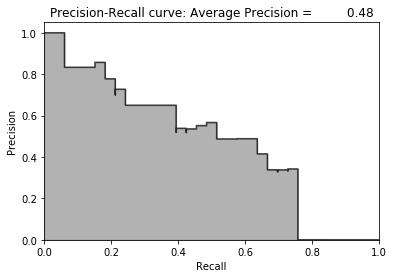

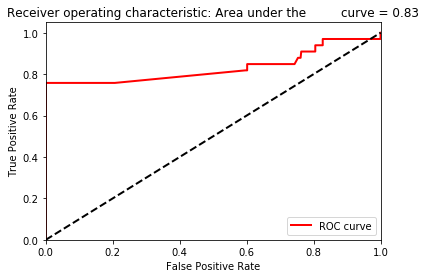

In [35]:
preds, average_precision = plotResults(y_train, predictionsBasedOnKFolds.loc[:,'prediction'], True)

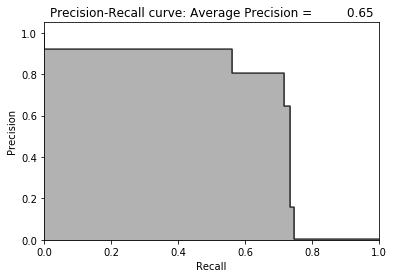

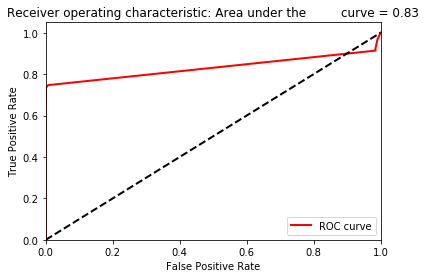

In [36]:
predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [37]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(f'{round(precision,4)}')

0.0312


In [38]:
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), index=X_train.columns,columns=['featImportance'])
featuresImportance = featuresImportance/featuresImportance.sum()
featuresImportance.sort_values(by='featImportance', ascending=False,inplace=True)
featuresImportance

,featImportance
V1,0.250000
V12,0.166667
37,0.083333
26,0.083333
V7,0.083333
...,...
2,0.000000
4,0.000000
V2,0.000000
6,0.000000
